## Healthcare spending as a percent of GDP

Nov 2024 Storytelling with Data Challenge (Improve on a bad chart)

Originally saw the visual I wanted to improve here https://www.commonwealthfund.org/publications/fund-reports/2024/sep/mirror-mirror-2024

Since that site didn't post the source data, I had to hunt around and find a close enough data source here https://www.healthsystemtracker.org/chart-collection/health-spending-u-s-compare-countries/#Per%20capita%20health%20expenditures,%20U.S.%20dollars,%20PPP%20adjusted,%202021%20and%202022%C2%A0

In [1]:
import datetime as dt
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
# read in data
df = pd.read_csv('..\healthcare_spending_as_percent_of_gdp.csv')

In [4]:
# reshape data
df = df.set_index('X.1').rename_axis('YEAR').melt(ignore_index=False, var_name='COUNTRY', value_name='VALUE').reset_index()

In [5]:
# convert Year to string data type
# this was necessary for me to format the X axis in the way that I did
df.YEAR = df.YEAR.astype(str)

### 1. Create Line Chart

In [32]:
# create line chart

color_domain = df['COUNTRY'].unique()
color_range = ['#FF4444' if x == 'United States' else 'grey' for x in df['COUNTRY'].unique()]

lines = alt.Chart(df).mark_line().encode(
    # format X axis to have a more attractive scale
    x=alt.X('YEAR', 
            axis=alt.Axis(
                labelExpr="datum.value == 1980 ? datum.value : \
                datum.value == 2000 ? datum.value :  \
                datum.value == 2022 ? \"'\" + slice(datum.value, -2) : \
                datum.value % 5 == 0 ? \"'\" + slice(datum.value, -2) : ''", \
                labelAngle=0,
                labelFontSize=14,
                domain=False,
                labelPadding=6,
                tickSize=alt.condition(
                    (alt.datum.value == '1980') | (alt.datum.value == '2000'),
                    alt.value(10),  # Extended tick size for 1980 and 2000
                    alt.value(5)    # Default tick size for other years
                )
            ),
           title=None),
    y=alt.Y('VALUE', axis=alt.Axis(
            labelExpr="datum.value != 20 ? datum.value : datum.value + '%'",
            gridDash=[4, 2],
            labelFontSize=14,
            domain=False,
            ticks=False,
            labelPadding=18,
            labelAlign='center'),
           title=None),
    # color United States and grey out all other countries
    color=alt.Color('COUNTRY', scale=alt.Scale(
                        domain=color_domain, 
                        range=color_range),
                        legend=None),
    # add slightly thicker line for United States
    strokeWidth=alt.condition(
    alt.datum.COUNTRY == 'United States',
    alt.value(3),  # Line weight for the United States
    alt.value(2.5)   # Line weight for other countries
),
    opacity=alt.condition(
    (alt.datum.COUNTRY == 'United States'),
    alt.OpacityValue(1),
    alt.OpacityValue(.3)),
).transform_filter(
    alt.datum.YEAR >= 1980
).transform_filter(
    alt.datum.COUNTRY != ('Comparable country average')
)

In [33]:
lines

alt.Chart(...)

### 2. Create text for floating US and non-US labels

In [9]:
# create position of US text
us_text_df = pd.DataFrame({'DATE': ['2012'],
                           'VALUE': [17.25]})
# plot US text
us_text = alt.Chart(us_text_df).mark_text(
    text='United States',
    fontSize=16,
    align='center',
    baseline='middle',
    dx=5  # Adjust the position of the text
).encode(
    alt.X('DATE'),
    alt.Y('VALUE'),
    color=alt.value('#FF4444')  # Color of the text
)

In [10]:
# text for countries other than US
non_us_text_df = pd.DataFrame({'DATE': ['2012'],
                               'VALUE': [7]})

# create position on separate lines for the countries
non_us = ['Comparable Developed Countries:',
          '(Australia, Austria, Belgium, Canada', 
          'France, Germany, Japan, Netherlands', 
          'Sweden, Switzerland, United Kingdom)']

# plot non-US text
text_other_countries = alt.Chart(non_us_text_df).mark_text(
    text=non_us,
    fontSize=14,
    align='center',
    baseline='middle',
    dx=5  # Adjust the position of the text
).encode(
    alt.X('DATE'),
    alt.Y('VALUE'),
    color=alt.value('grey')  # Color of the text
)

### 3. Combine line chart and floating labels, with chart title and final formatting

In [34]:
# create title
title=alt.Title(
       'Health Care Spending as a Percentage of GDP, 1980–2022')

# combine all subplots
(lines + us_text + text_other_countries).properties(
    title=title,
    padding=20,
height=400,
width=675).configure_title(
    font='Arial',
    fontSize=23,
    anchor='middle',
    align='center',
    offset=10,
    fontWeight='normal' # by default the weight is bold
).configure_view( # turn off border around the plot
    stroke=None
).configure_axis(
    domainOpacity=0  # remove the solid vertical lines along the X and Y axis
).display(
    scaleFactor=8
)

alt.LayerChart(...)

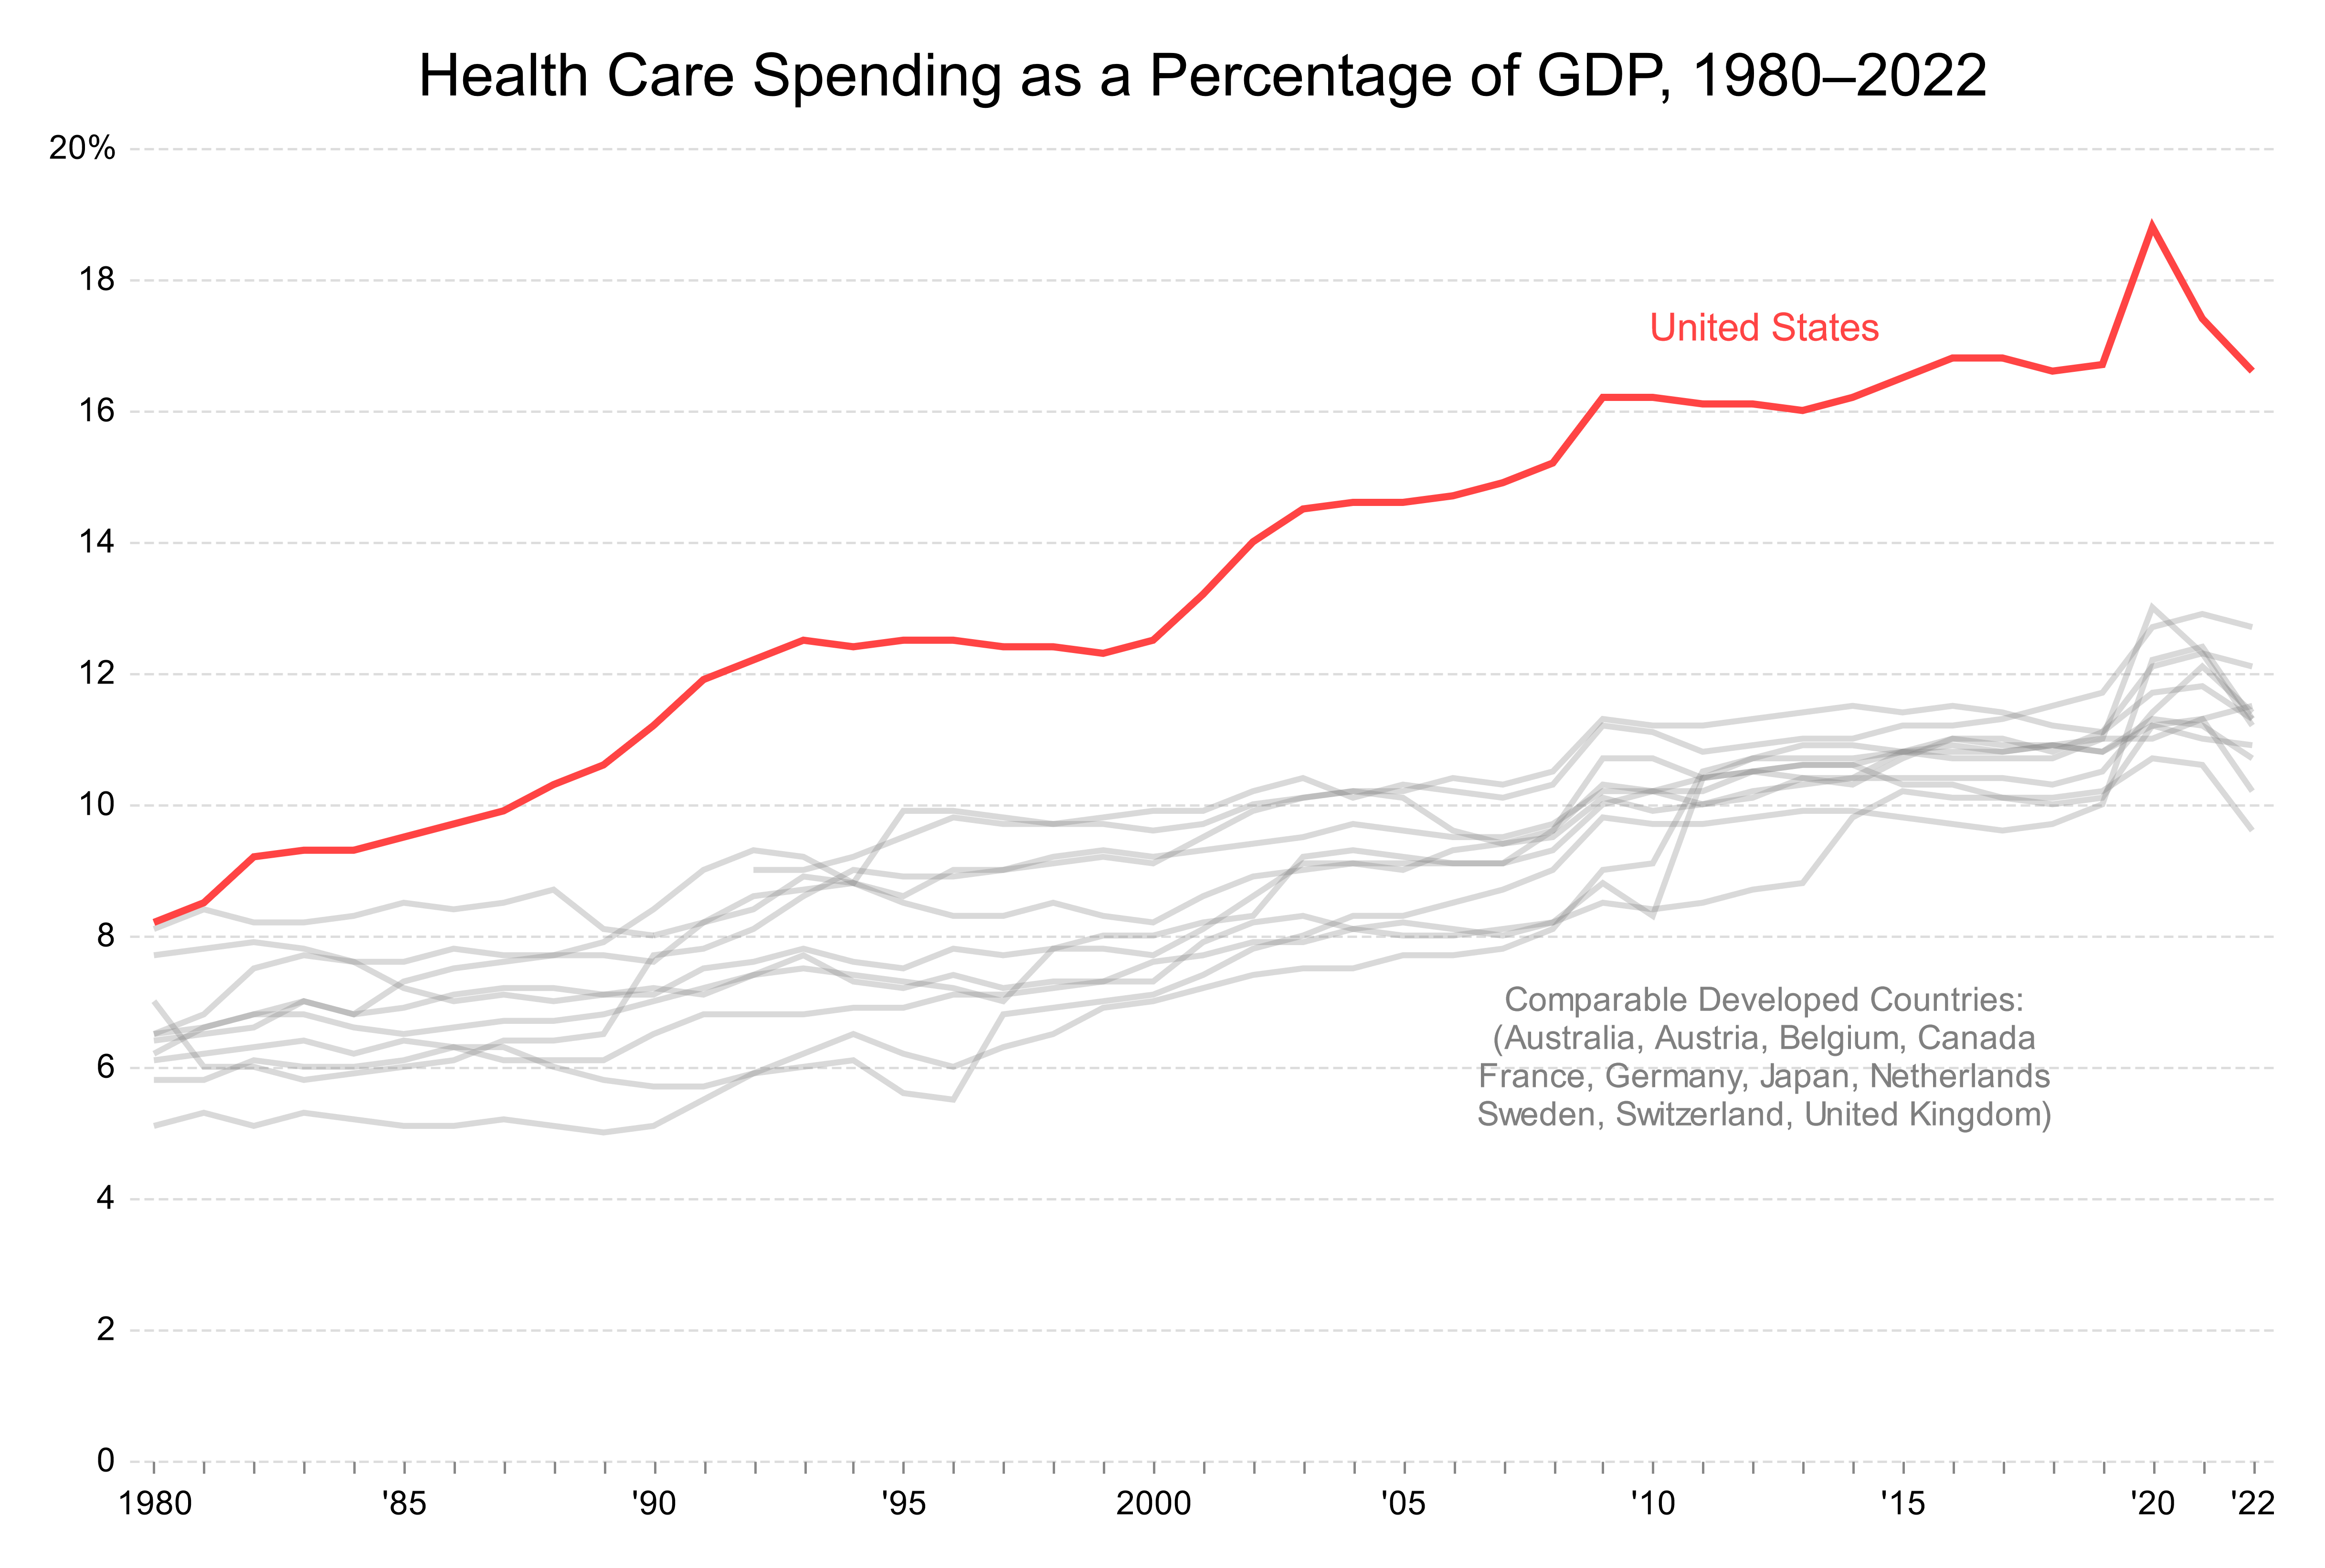

In [2]:
from IPython.display import Image
Image(filename='health_care_spending_percent_gdp.png')